# `Практикум по программированию на языке Python`

## `Задание 01. Полносвязная нейронная сеть на numpy`.

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__20 февраля__</span>.

Мягкий дедлайн: <span style="color:red">__6 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __3 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

In [168]:
import numpy as np
from numpy import vectorize
from scipy.special import logsumexp
from icecream import ic
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
%matplotlib inline


## `Теоретическая часть (3 балла)`

В этом блоке вам нужно решить 3 задания.

### `Задание 1. Градиенты для слоя Batch normalization (1.5 балла)`

Рассмотрим слой Batch normalization. Пусть на вход этого слоя был подан батч из $n$ объектов, при этом у всех объектов по 1 признаку. Представим вход BN слоя в виде $X \in \mathbb{R}^{n \times 1}$.

Тогда в этом слое производятся следующие вычисления:

$$ \mu = \frac1n \sum_{i=1}^{n} X_i $$

$$ \sigma^2 = \frac1n \sum_{i=1}^{n} \left( X_i - \mu \right) ^2 $$

$$ \tilde{y_i} = \frac{X_i - \mu}{\sqrt{\sigma^2 + \varepsilon}} $$

$$ y_i = \gamma \tilde{y_i} + \delta $$

Выходом BN слоя является $y_i$, а $\gamma,\delta\in\mathbb{R}$ — параметры, которые подбираются во время обучения вместе с другими параметрами нейронной сети (наряду, например, с весами линейного слоя).

Рассмотрим нейронную сеть, в которой есть BN слой. Предположим, что вычисления в нейронной сети завершаются подсчетом функции потерь $\mathcal{L}$. Пусть мы выполнили прямой проход по нейронной сети и сейчас делаем обратный проход с помощью метода обратного распространения ошибки. Пусть BN слою пришел градиент функции потерь по выходу BN слоя ($\nabla_{y} \mathcal{L}$).

В этом задании вам нужно записать вычисление градиента функции потерь по параметрам слоя BN $\gamma$ и $\delta$ ($\nabla_{\gamma} \mathcal{L}$, $\nabla_{\delta} \mathcal{L}$) через $\nabla_{y} \mathcal{L}$, а также вам нужно записать вычисление градиента функции потерь по входу слоя BN $X$ ($\nabla_{X} \mathcal{L}$) через $\nabla_{y} \mathcal{L}$.

Хочу заметить, в данном задании мы рассматриваем объекты всего с 1 признаком, чтобы упростить выкладки.

__Ваше решение:__

---

Сперва посмотрим, как производится дифференцирование сложных функций. Посмотрим на простейший пример композиции скалярных функций.

$$
  \begin{equation*}
    \left\{
      \begin{aligned}
        & Y: \mathbb{R} \longmapsto \mathbb{R} \\
        & x \: : \mathbb{R} \times \mathbb{R} \longmapsto \mathbb{R}
      \end{aligned}
    \right.
  \end{equation*}

  \Longrightarrow Y(x(a, b)), \:\: a, b \in \mathbb{R} \Longrightarrow 

  \begin{equation*}
    \left\{
      \begin{aligned}
        & \nabla_{x}Y = \frac{\partial Y}{\partial x} \\
        & \Rightarrow \nabla_{a}Y = \frac{\partial x}{\partial a} \nabla_{x}Y = \frac{\partial Y}{\partial x} \frac{\partial x}{\partial a}\\
        & \Rightarrow \nabla_{b}Y = \frac{\partial x}{\partial b} \nabla_{x}Y = \frac{\partial Y}{\partial x} \frac{\partial x}{\partial b}
      \end{aligned}
    \right.
  \end{equation*}
$$

Данный пример наглядно показывает модель распространения градиента при вычислении частных производных сложных функций. Однако для нашей задачи исходный градиент раскрывается как $\nabla_y \mathcal{L} = \left \{ \frac{\partial \mathcal{L}}{\partial y_1} \: \dotsi \frac{\partial \mathcal{L}}{\partial y_k} \right \}$, а это уже является более сложным случаем матричного дифференцирования. В таком случае введем оператор дифференцирования, действующий на объекты из пространств $\mathbb{R}, \, \mathbb{R}^m \, \text{и} \, \mathbb{R}^{m \times n}$, обозначим его в виде $D$ и для него выпишем интересующее нас свойство $\left[D_{x_0}(u \circ v)\right](h)=\left[D_{v\left(x_0\right)} u\right]\left(\left[D_{x_0} v\right](h)\right)$. С помощью свойства найдем градиенты для слоя BN $( \nabla_{\gamma} \mathcal{L}$, $\nabla_{\delta} \mathcal{L} )$


$$
  \begin{equation*}
    \left\{
      \begin{aligned}
        & \left \langle \nabla_{\gamma} \mathcal{L}, \: h \right \rangle= \left \langle \nabla_{\gamma} \mathcal{L}(y(\gamma, \delta, X)), \: h \right \rangle= \left[ \nabla_{y} \mathcal{L} \right] \left( \nabla_{\gamma} y \, d\gamma \right) = \left \langle \nabla_{y} \mathcal{L}, \: \nabla_{\gamma} y \, d\gamma \right \rangle = \left \langle \nabla_{\gamma}^\intercal y \, \nabla_{y} \mathcal{L}, \: d \, \gamma \right \rangle \\

        & \left \langle \nabla_{\delta} \mathcal{L}, \: h \right \rangle= \, \left \langle \nabla_{\delta} \mathcal{L}(y(\gamma, \delta, X)), \: h \right \rangle= \left[ \nabla_{y} \mathcal{L} \right] \left( \nabla_{\delta} y \, d\delta \right) \, = \left \langle \nabla_{y} \mathcal{L}, \: \nabla_{\delta} y \, d\delta \right \rangle \, = \left \langle \nabla_{\delta}^\intercal y \, \nabla_{y} \mathcal{L}, \: d \, \delta \right \rangle
      \end{aligned}
    \right.
  \end{equation*}

  \Longrightarrow 

  \begin{equation*}
    \left\{
      \begin{aligned}
        & \nabla_{\gamma} \mathcal{L} = \nabla_{\gamma}^\intercal y \, \nabla_{y} \mathcal{L} = \tilde{y}^\intercal \, \nabla_{y} \mathcal{L} \\
        & \nabla_{\delta} \mathcal{L} \, = \nabla_{\delta}^\intercal y \, \nabla_{y} \mathcal{L} = \sum^n_{i=1} \nabla_{y}^i \mathcal{L}
      \end{aligned}
    \right.
  \end{equation*}
$$

Легко заметить, что, например, формула для $\nabla_{\gamma} \mathcal{L}$ совпадает с аналитической формулой поэлементного дифференцирования фектора: $\left \{ \frac{\partial \mathcal{L}}{\partial y_1} \frac{\partial y_1}{\partial \gamma} \: \dotsi \frac{\partial \mathcal{L}}{\partial y_k} \frac{\partial y_k}{\partial \gamma} \right \}$

Однако таким образом дифференцирование может быть слишком кропотливой и долгой задачей для сильно вложенных композиций функций. Потому решим задачу общим способом через дифференциалы, воспользовавшись инвариантностью формы перого дифференциала функции:

$$
  \begin{equation*}
    \left\{
      \begin{aligned}
      & d \mathcal{L} = \left \langle \nabla_y \mathcal{L}, dy \right \rangle \\

      & d \mathcal{L} = \left \langle \nabla_\gamma \mathcal{L}, d \gamma \right \rangle + \left \langle \nabla_{\tilde{y}} \mathcal{L}, d \tilde{y} \right \rangle + \left \langle \nabla_\delta \mathcal{L}, d \delta \right \rangle \\

      & d y = \tilde{y} d \gamma + \gamma d \tilde{y} + \mathbb{I} d \delta
      \end{aligned}
    \right.
  \end{equation*}

  \Longrightarrow 

  \left \langle \nabla_y \mathcal{L}, \tilde{y} d \gamma + \gamma d \tilde{y} + \mathbb{I} d \delta \right \rangle = \left \langle \nabla_\gamma \mathcal{L}, d \gamma \right \rangle + \left \langle \nabla_{\tilde{y}} \mathcal{L}, d \tilde{y} \right \rangle + \left \langle \nabla_\delta \mathcal{L}, \mathbb{I} d \delta \right \rangle

  \Longrightarrow 

  \begin{equation*}
    \left\{
      \begin{aligned}
      & \nabla_{\gamma} \mathcal{L} = \tilde{y}^\intercal \, \nabla_{y} \mathcal{L} \\

      & \nabla_{\delta} \mathcal{L} = \mathbb{I}^\intercal \nabla_{y} \mathcal{L} \\

      & \nabla_{\tilde{y}} \mathcal{L} = \gamma \nabla_{y} \mathcal{L}
      \end{aligned}
    \right.
  \end{equation*}
$$

Видно, что мы вывели те же самые формулы для дифференциалов слоя BN, полученные нами ранее через явное свойство дифференцирования сложных функций. Осталось же найти дифференциал по входу функции. Для этого распространим дифференциал с $\nabla_{\tilde{y}} \mathcal{L}$ далее на входы $X$

$$d \mathcal{L} = \left \langle \nabla_X \mathcal{L}, \, d X \right \rangle = \left \langle \nabla_{\tilde{y}} \mathcal{L}, \, d \tilde{y} \right \rangle ; \; \; \; 
    y = \frac{X - \mathbb{I} \mu}{\sqrt{\sigma^2 + \varepsilon}} ; \; \; \;
    \mu = \frac{1}{n} \mathbb{I} ^ \intercal X; \; \; \;
    \sigma^2 = \frac{1}{n} \left \langle X, X \right \rangle - (2 - \frac{1}{n}) \mu ^ 2$$

$$
  \begin{equation*}
    \left\{
      \begin{aligned}
      & d \mu = d \left ( \frac{1}{n} \mathbb{I} ^ \intercal X \right) = \frac{1}{n} \mathbb{I} ^ \intercal d X \\
      
      & d \sigma ^ 2 = d \left (\frac{1}{n} \left \langle X, X \right \rangle - \frac{1}{n}(2 - \frac{1}{n}) \mu ^ 2 \right) = 
        \frac{1}{n} \left \langle \left ( E + E^\intercal \right) X, d X \right \rangle - \mu (\frac{4}{n} - \frac{2}{n^2}) \mathbb{I} ^ \intercal d X =
        \frac{2}{n} X ^ \intercal d X  - \mu (\frac{4}{n} - \frac{2}{n^2}) \mathbb{I} ^ \intercal d X\\

      & d \tilde{y} = \frac{\left ( E \, d X - \mathbb{I} d \mu \right)}{\sqrt{\sigma^2 + \varepsilon}} - 
        \left ( X - \mathbb{I} \mu \right) \frac{d \sigma^2}{2 (\sqrt{\sigma^2 + \varepsilon}) ^ 3} = 

        \left (\frac{E - \frac{1}{n} \mathbb{I} \, \mathbb{I}^\intercal}{\sqrt{\sigma ^ 2 + \varepsilon}} - 
        \left ( X - \mathbb{I} \mu \right) \frac{\frac{1}{n} X^\intercal - \mu \left( \frac{2}{n} - \frac{1}{n^2} \right) \mathbb{I} ^ \intercal}{(\sqrt{\sigma^2 + \varepsilon}) ^ 3} \right ) d X = W \, d X
      \end{aligned}
    \right.
  \end{equation*}
$$

$\Rightarrow \nabla_X \mathcal{L} = W^\intercal \nabla_{\tilde{y}} \mathcal{L} = \gamma \left (\frac{E - \frac{1}{n} \mathbb{I} \, \mathbb{I}^\intercal}{\sqrt{\sigma ^ 2 + \varepsilon}} - \left ( X - \mathbb{I} \mu \right) \frac{\frac{1}{n} X^\intercal - \mu \left( \frac{2}{n} - \frac{1}{n^2} \right) \mathbb{I} ^ \intercal}{(\sqrt{\sigma^2 + \varepsilon}) ^ 3} \right ) \nabla_{\tilde{y}} \mathcal{L}$


__Ответ:__

1. $\nabla_{\gamma} \mathcal{L} = \tilde{y}^\intercal \, \nabla_{y} \mathcal{L}$

2. $\nabla_{\delta} \mathcal{L} = \mathbb{I}^\intercal \nabla_{y} \mathcal{L}$

3. $\nabla_X \mathcal{L} = \gamma \left (\frac{E - \frac{1}{n} \mathbb{I} \, \mathbb{I}^\intercal}{\sqrt{\sigma ^ 2 + \varepsilon}} - \left ( X - \mathbb{I} \mu \right) \frac{\frac{1}{n} X^\intercal - \mu \left( \frac{2}{n} - \frac{1}{n^2} \right) \mathbb{I} ^ \intercal}{(\sqrt{\sigma^2 + \varepsilon}) ^ 3} \right ) \nabla_{\tilde{y}} \mathcal{L}$

---

### `Задание 2. Вывод инициализации весов линейного слоя при использовании ReLU в качестве функции активации (1 балл)`

Рассмотрим полносвязную нейронную сеть с функцией активации $g(y)$. Пусть сеть состоит из $L$ слоев и размер входа слоя $l$ равен $n_l\ \ (l = \overline{1, L})$.

Обозначим за $x^l \in \mathbb{R}^{n_{l}}$ вход слоя $l$, за $y^l \in \mathbb{R}^{n_{l+1}}$ — выход слоя $l$, за $W^l \in \mathbb{R}^{n_{l+1} \times n_{l}}$ — веса слоя $l$, за $b^l \in \mathbb{R}^{n_{l+1}}$ — вектор сдвига слоя $l$.

Тогда
$$y^l = W^l x^l + b^l,$$
$$x^{l+1} = g(y^l).$$

На паре вы выводили хорошую инициализацию для линейного слоя в случае, когда в качестве функции активации $g(y)$ в нейронной сети используется гиперболический тангенс $g(y) = \tanh(y)$. Сейчас вам нужно сделать подобный вывод для случая, когда в сети в качестве функций активации используется $g(y) = ReLU(y) = \max(0, y)$.

Сделаем следующие предположения насчет того, как распределены веса $W^l$, вектор сдвига $b^l$, входной вектор $x^l$, выходной вектор $y^l$ линейного слоя и градиенты функции потерь $\frac{\partial L}{\partial y^{l}}$ $(l = \overline{1, L}$):

1. Все компоненты в $W^l$ распределены одинаково и независимо друг от друга;
2. Все компоненты в $y^l$ распределены одинаково и независимо друг от друга;
3. Все компоненты в $x^l$ распределены одинаково и независимо друг от друга;
4. Все компоненты в $\frac{\partial L}{\partial y^{l}}$ распределены одинаково и независимо друг от друга;
5. Все компоненты в $W^l$ и все компоненты в $x^l$ независимы друг от друга;
6. Все компоненты в $W^l$ имеют четную плотность распределения (то есть симметричную относительно нуля: $p_{W^l}(-x) = p_{W^l}(x)$);
7. Все компоненты в $W^l$ имеют конечное матожидание;
8. Вектор $b^l$ инициализирован нулями.


Подсказки:
1. Из пунктов 6 и 7 следует, что все компоненты в $W^l$ имеют нулевое среднее ($\mathbb{E} W^l_{ij} = 0\ \ \forall i = \overline{1, n_{l+1}}, j = \overline{1, n_{l}}$) (докажите);
2. Из пунктов 6 и 7 следует, что все компоненты в $y^l$ имеют нулевое среднее и четную плотность распределения (докажите).

__Ваше решение:__

---

Докажем пункты подсказок:
- $\exists \mathbb{E} W_{ij}^l \, \Rightarrow \exists  \int_{-\infty}^{\infty} p(x) dx = \int_{0}^{\infty} p(x) dx + \int_{-\infty}^{0} p(x) dx = \int_{0}^{\infty} p(x) dx - \int^{\infty}_{0} p(-x) dx = \text{условие четноси плотности} = \int_{0}^{\infty} p(x) dx - \int^{\infty}_{0} p(x) dx \equiv 0 $
- Для произвольного $y_{i}^l$ справедливо представление: $\sum_{j = 1}^{n_l} w_{ij}^l x^l_j + b_i^l$ - считая, что все значения $w_{ij}^l$ пришли из распределений с нулевым мат. ожиданием и четной плотностью распределения, то используя линейность оператора взятия мат. ожидания и равенства нулю все $b_i^l$, раскрыв все x^l_j по формулам, как они получаются из y_j^{l-1}, найдем, что $\mathbb{E}y_{i}^l = 0$, из этого же следует и четность $\frac{\partial}{\partial x} \mathbb{P}(y_{i}^l < x)$

---

Перейдем к анализу способа инициализации:
Обозначим цель поиска специальных средств инициализации весов: мы хотим обеспечить отсутсвие затухания или сильных всколыханий градиента в процессе обучения модели. Потому требуется, чтобы активационная способность всех слоев была одинаковой и в среднем реакция всех слоев к объектам оставалсь одинаковой. Потому выражаются требования:

1.  $\mathbb{E} y^l = \mathbb{E} y^{l=1};  \; \; \mathbb{D} y^l = \mathbb{D} y^{l+1}$
2.  $\mathbb{E} \delta^l = \mathbb{E} \! \; \delta^{l=1}; \; \; \mathbb{D} \delta^l = \mathbb{D} \delta^{l+1}$

Посмотрим на прямой проход по сети:

$$\mathbb{D} y^l_i = \mathbb{D} \sum\limits_{j = 1}^{n_l}W_{ij}^l x^l_j = \{\text{из независимости $W_{ij}^l$ и $x^l$}\} = \sum\limits_{j = 1}^{n_l} \mathbb{D} W_{ij}^l  \mathbb{D} x^l_j = n_l \mathbb{D} W^l \mathbb{D} x^l, \; \text{обозначив через переменные без индексов общий вид переменных по слою}$$

Теперь обратимся к общему виду $x^l$ зная, что для его получения используется функция активации ReLU: $x^{l+1} = ReLU(y^l) = ReLU(W^l x^l + b^l) = (W^l x^l + b^l)^+$. Подставляя данную формулу в полученное ранее уравнение для дисперсии $\mathbb{D} y^l_i = n_l \mathbb{D} W^l \mathbb{D} \, ReLU(y^{l-1}) = n_l \mathbb{D} W^l \mathbb{D} (y^{l-1})^+$, видим, что нам необходимо рассматривать не изначальные СВ $y^{l-1}$, а величины их положительных срезок. Сделать это мы можем, так как функция $max(0, x)$ есть измеримая относительно измеримого пространства $(\mathbb{R}, \mathcal{B})$ отображение, а значит и $max(0, \xi), \; \text{где} \; \xi \; \text{так же является СВ - является случайной величиной над изначальным вероятностным пространством}$. Найдем дисперсию $\mathbb{D} (y^{l-1})^+$.

$$ \mathbb{D} (y^l)^+ = \mathbb{E} ((y^l)^+)^2 - \left( \mathbb{E} (y^l)^+ \right)^2, \text{положим, что} \; y^l \; \text{пришло из абсолютно непрерывного распределения. Тогда} \; 
\begin{equation*}
    \left\{
      \begin{aligned}

        & \mathbb{E} ((y^l)^+)^2 = \int\limits_{-\infty}^{\infty} (y^l)^2 p_{(y^l)^+}(x) dx = \int\limits_{0}^{\infty} (y^l)^2 p_{y^l}(x) dx = \frac{1}{2} \mathbb{E} (y^l)^2 \\

        & \mathbb{E} (y^l)^+ = \int\limits_{-\infty}^{\infty} (y^l)^+ p_{(y^l)^+}(x) dx = \int\limits_{0}^{\infty} y^l p_{y^l}(x) dx

        \end{aligned}
    \right.
\end{equation*}

$$

---



### `Задание 3. Почему функция активации` $ReLU(y) = \max(0, y)$ `предпочтительней сигмоиды` $\sigma(y) = \frac{1}{1 + \exp(-y)}$ `в нейронных сетях? (0.5 балла)`

Дайте развернутый ответ на вопрос "Почему функция активации $ReLU(y) = \max(0, y)$ предпочтительней сигмоиды $\sigma(y) = \frac{1}{1 + \exp(-y)}$ в нейронных сетях?"

__Ваш ответ:__

Функция активации $ReLU$ обладает рядом положительных качеств, по сравнению с сигмоидальной функцией. Перове, что хочется упомянуть, это расходы на вычисление функции активации на каждом входе: если вычислительная сложность ReLU складывается лишь из операциии ветвления, то для вычисления сигмоидальной функции требуется провести вычисление экспоненты и плюс деления 1 на результат. То же самое можно сказать и о вычислении производной. Разница в закладываемых ресурсах с ростом сети колосальна. При этом сигмоидальная функция ограничивает значения параметров на сегменте $[0; 1]$ для $x \in \mathbb{R}$. Такое поведение может показаться крайне полензным, однако из самой формы сигмоиды исходит и главнейшая проблема: затухание градиента. Производная функйции сигмоиды ограничена на $\mathbb{R}$ и при этом быстро стремится к нулю при $x \rightarrow \pm \infty$, из-за чего градиент быстро стремится к нулю с ростом слоев от выхода нейросети.

## `Практическая часть (7 баллов)`

### `Реализация нейронной сети (3 балла)`

В этом задании вы обучите полносвязную нейронную сеть распознавать рукописные цифры (а что же еще, если не их :), [почти] самостоятельно реализовав все составляющие алгоритма обучения и предсказания.

Для начала нам понадобится реализовать прямой и обратный проход через слои. Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

In [2]:
class IdentityLayer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           
    output = layer.forward(input)

    - Propagate gradients through itself:    
    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters.

    Modified code from cs.hse DL course *
    """

    def __init__(self):
        """
        Here you can initialize layer parameters (if any) 
        and auxiliary stuff. You should enumerate all parameters
        in self.params
        """
        # An identity layer does nothing
        self.params = []
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], 
        returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        self.input = input
        return input

    def backward(self, grad_output):
        """
        Performs a backpropagation step through the layer, 
        with respect to the given input.

        To compute loss gradients w.r.t input, 
        you need to apply chain rule (backprop):

        d `loss` / d `input` = (d `loss` / d `layer`) * (d `layer` / d `input`)

        Luckily, you already receive d `loss` / d `layer` in argument, 
        so you only need to multiply it by d `layer` / d `input`.

        NB: Sometimes d `layer` / d `input` can be a 3D or even 4D tensor.
        So it's better to write down the `loss` differential and extract
        d `layer` / d `input` from it so that only 2D tensors were present.

        The method returns:
        * gradient w.r.t input (will be passed to 
          previous layer's backward method)
        * flattened gradient w.r.t. parameters (with .ravel() 
          applied to each gradient). 
          If there are no params, return []
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = self.input.shape[1]

        d_layer_d_input = np.eye(input_dim)

        return np.dot(grad_output, d_layer_d_input), []  # chain rule

#### `Слой нелинейности ReLU`

Для начала реализуем слой нелинейности $ReLU(y) = \max(0, y)$. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения $ReLU$ к входному массиву, метод `backward` — градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить как атрибут класса.

In [320]:
class ReLU:
    """
    Modified code from cs.hse DL course *
    """

    def __ReLU(self, c):
        return lambda x: x if x > 0 else c

    def __RelU_grad(self, c):
        return lambda x: 1 if x > 0 else c

    def __init__(self, leaky=None):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        self.params = []  # ReLU has no parameters

        self.relu = vectorize(self.__ReLU(
            leaky if leaky is not None else 0), otypes=[np.float32])
        self.relu_grad = vectorize(self.__RelU_grad(
            leaky if leaky is not None else 0), otypes=[np.float32])

    def forward(self, input):
        """Apply elementwise ReLU to [batch, num_units] matrix"""
        # your code here
        self.input = input
        return self.relu(input)

    def backward(self, grad_output):
        """Compute gradient of loss w.r.t. ReLU input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        # your code here
        layer_grad = self.relu_grad(self.input)
        return layer_grad * grad_output, []

    def __repr__(self):
        return 'Relu()'

#### `Полносвязный слой`

Далее реализуем полносвязный слой без нелинейности. У слоя два параметра: матрица весов и вектор сдвига.

Обратите внимание на второй аргумент: в нем надо возвращать градиент по всем параметрам в одномерном виде. Для этого надо сначала применить `.ravel()` ко всем градиентам, а затем воспользоваться `np.r_`:

In [121]:
# example
np.r_[np.eye(3).ravel(), np.arange(4)]

array([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 3.])

In [120]:
np.random.randn(3, 4)

array([[ 0.03562097, -1.8288803 ,  1.00096229,  0.77431848],
       [-0.03081312,  0.01410933,  1.36553788, -0.96858833],
       [ 0.65188578,  0.08472743,  0.55946508,  0.21624476]])

In [389]:
class Dense:
    """
    Modified code from cs.hse DL course *
    """

    def __init__(self, input_units, output_units):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = x W + b
        """
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        self.params = [self.weights, self.biases]

    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = x W + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        # your code here
        self.input = input
        return input @ self.weights + self.biases

    def backward(self, grad_output):
        """
        compute gradients
        grad_output shape: [batch, output_units]
        output shapes: [batch, input_units], [num_params]

        hint: use function np.r_
        np.r_[np.arange(3), np.arange(3)] = [0, 1, 2, 0, 1, 2]
        """
        # your code here

        layer_grad_weights = self.input.T @ grad_output
        layer_grad_bias = np.sum(grad_output, axis=0)
        back_grad_output = grad_output @ self.weights.T

        return back_grad_output, np.r_[layer_grad_weights.ravel(), layer_grad_bias.ravel()]

    def __repr__(self):
        return f'Dense({self.weights.shape[0]}, {self.weights.shape[1]})'

#### `Проверка градиента`

Проверим правильность реализации с помощью функции численной проверки градиента. Функция `eval_numerical_gradient` принимает на вход callable объект `f` (функцию от одного аргумента-матрицы) и аргумент `x` и вычисляет приближенный градиент функции `f` в точке `x`.

In [99]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """
    Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        # if verbose:
        #     print(ix, grad[ix])
        it.iternext()  # step to next dimension

    return grad

Вычислите аналитический и численный градиенты по входу слоя ReLU от функции
$$ f(y) = \sum_i y_i, \quad y = ReLU(x) $$

Выпишите аналитический градиент в этой ячейке:

$$\frac{\partial}{\partial x_{ij}} f(y) = \begin{equation*}
    \left\{
      \begin{aligned}
      & 0, x_{ij} \leq 0 \\
      & 1, x_{ij} \gt 0
      \end{aligned}
    \right.
  \end{equation*}
  $$

Следующая ячейка после заполнения должна не выдавать ошибку :)

In [ ]:
relu = ReLU()
points = np.linspace(-1, 1, 10*12).reshape([10, 12])

# your code here


def SumReLU(x):
    # ic(relu.forward(x))
    return np.sum(relu.forward(x))


# analitical grad
relu.forward(points)
grads = relu.backward(np.ones_like(points))[0]

# numerical grad
numeric_grads = np.ndarray(points.shape)
for i in range(points.shape[0]):
    numeric_grads[i, :] = eval_numerical_gradient(
        SumReLU, points[i, :], verbose=False)

ic(numeric_grads, grads, points)

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

Вычислите аналитический и численный градиенты по входу полносвязного слоя от функции
$$ f(y) = \sum_i y_i, \quad y = W x + b $$

Выпишите аналитический градиент в этой ячейке (советуем выписать градиент через дифференциал функции $f$):

$$\left \langle \nabla_y \mathcal{L}, d y \right \rangle = \left \langle \nabla_W \mathcal{L}, d W \right \rangle + \left \langle \nabla_b \mathcal{L}, d b \right \rangle$$

$$ 
  dy = d \left ( Wx + b \right ) = d W x + W d x + d b \Longrightarrow 

  \begin{equation*}
    \left\{
      \begin{aligned}
      & \left \langle \nabla_y \mathcal{L}, d W x \right \rangle = \left \langle \nabla_y \mathcal{L} x^\intercal, d W \right \rangle \\
      & \left \langle \nabla_y \mathcal{L}, W dx \right \rangle = \left \langle W^\intercal \nabla_y \mathcal{L}, d x \right \rangle \\
      & \left \langle \nabla_y \mathcal{L}, d b \right \rangle 
      \end{aligned}
    \right.
  \end{equation*}

  \Longrightarrow 

  \begin{equation*}
    \left\{
      \begin{aligned}
      & \nabla_W \mathcal{L} = \nabla_y \mathcal{L} x^\intercal \\
      & \nabla_x \mathcal{L} = W^\intercal \nabla_y \mathcal{L} \\
      & \nabla_b \mathcal{L} = \nabla_y \mathcal{L}
      \end{aligned}
    \right.
  \end{equation*}
$$

Следующая ячейка после заполнения должна не выдавать ошибку :)

In [380]:
linear = Dense(12, 32)
points = np.linspace(-1, 1, 10*12).reshape([10, 12])

# your code here


def SumGradWeights(x):
    return np.sum(linear.forward(x))


# analitical grad
linear.forward(points)
grads, t = linear.backward(np.ones((10, 32)))

# numerical grad
numeric_grads = np.ndarray((points.shape))
for i in range(numeric_grads.shape[0]):
    numeric_grads[i, :] = eval_numerical_gradient(
        SumGradWeights, points[i, :], verbose=False)

# ic(numeric_grads)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

In [381]:
t[1].shape

(32,)

#### `Реализация softmax-слоя и функции потерь`

Для решения задачи многоклассовой классификации обычно используют $softmax$ в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:
$$\hat y = softmax(x)  = \left \{\frac {\exp(x^i)}{\sum_{j=1}^K \exp(x^j)} \right \}_{i=1}^K, \quad K - \text{число классов.}$$

Здесь за $x^i$ мы обозначаем $i$-ый признак объекта $x$.

В качестве функции потерь выберем отрицательный логарифм правдоподобия (по английски: negative log likelihood или NLL)
$$L(y, \hat y) = -\sum_{i=1}^K y^i \log \hat y^i,$$
где $y^i = 1$, если объект принадлежит $i$-му классу, и $y^i = 0$ иначе.

NLL совпадает с выражением для [кросс-энтропии](https://ru.wikipedia.org/wiki/Перекрёстная_энтропия) (в качестве первого распределения берем вырожденное распределение $y$, в качестве второго — предсказанное распределение $\hat y$). Очевидно, что эту функцию потерь также можно переписать через индексацию, если через $y$ обозначить класс данного объекта:
$$L(y, \hat y) = - \log \hat y_{y}$$

В таком виде ее удобно реализовывать.

Для обучения нейронной сети будем оптимизировать эту функцию потерь по параметрам нейронной сети:

$$ \frac1N \sum_{i=1}^N L(y_i, \hat y_i) = \frac1N \sum_{i=1}^N L(y_i, \text{NN}(x_i)) \rightarrow \min_{w}\,,$$
где за $x_i$ и $y_i$ мы обозначили признаки и таргет $i$-ого объекта обучающей выборки, за $\text{NN}$ мы обозначили нейронную сеть, которая по признакам объекта $x_i$ выдает распределение вероятностей $\hat y_i$, за $w$ мы обозначили все веса нейронной сети, а $N$ — это число объектов в обучающей выборке.

Реализуйте слой `LogSoftmax` (у этого слоя нет параметров). Метод `forward` должен вычислять логарифм от $softmax$, а метод `backward` — пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде.  Поэтому мы будем предполагать, что аргумент `grad_output` — это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

**Пожелание.** Постарайтесь максимально упростить формулу градиентов, чтобы получился лаконичный и стабильный код. Большие и страшные реализации часто оказываются нестабильными.

In [28]:
# from scipy.special import logsumexp
# use this function instead of np.log(np.sum(np.exp(...))) because it is more stable

In [421]:
class LogSoftmax:
    def __init__(self):
        self.params = []

    def forward(self, input):
        """
        Applies softmax to each row and then applies component-wise log
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        """
        # your code here
        self.input = input

        return input - logsumexp(input, axis=-1, keepdims=True)

    def backward(self, grad_output):
        """
        Propagartes gradients.
        Assumes that each row of grad_output contains only 1 
        non-zero element
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        Do not forget to return [] as second value (grad w.r.t. params)
        """
        # your code here
        X = np.exp(self.input).astype(np.float64)
        sum_exp = np.sum(X, axis=-1, keepdims=True)
        sum_init = np.sum(grad_output, axis=-1, keepdims=True)

        grad = grad_output - sum_init * X / sum_exp

        return grad, []

    def __repr__(self):
        return 'LogSoftmax()'

In [30]:
sf = LogSoftmax()
points = np.linspace(-1, 1, 10*12).reshape([10, 12])

# your code here


def SumSoftMax(x):
    return np.sum(sf.forward(x))


# analitical grad
sf.forward(points)
grads = sf.backward(np.ones((10, 12)))[0]

# numerical grad
numeric_grads = np.ndarray((points.shape))
for i in range(numeric_grads.shape[0]):
    numeric_grads[i, :] = eval_numerical_gradient(SumSoftMax, points[i, :])

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

Реализуйте функцию потерь и градиенты функции потерь. Во время вычисления NLL усредняйте (а не суммируйте) значения функции потерь по батчу. Обычно так делают для того, чтобы при двух запусках обучения нейронной сети с разными размерами батча получаемые значения функции потерь у этих сетей были сравнимы.

In [219]:
def NLL(activations, target):
    """
    Returns negative log-likelihood of target under model represented by
    activations (log probabilities of classes, it's just output of LogSoftmax layer).
    `activations` has shape [batch, num_classes], `target` has shape [batch]
    Output shape: 1 (scalar).
    """
    # your code here
    answ = np.mean(-activations[np.arange(len(target)), target])
    return answ


def grad_NLL(activations, target):
    """
    Returns gradient of negative log-likelihood w.r.t. activations.
    each arg has shape [batch, num_classes]
    output shape: [batch, num-classes]
    """
    # your code here
    answ = np.zeros(activations.shape)
    answ[np.arange(len(target)), target] = 1

    return (np.exp(activations) - answ) / len(target)

Наконец, выполните проверку `LogSoftmax`-слоя, используя функцию потерь и ее градиент:

In [218]:
n = 50
d = 10
lsm = LogSoftmax()
target = np.random.choice(d, size=n)
points = np.random.uniform(-1, 1, n*d).reshape([n, d])

# your code here


def get_loss(x):
    sf = lsm.forward(x)
    return NLL(sf, target)


# analitical grad
lsm_out = lsm.forward(points)
loss_grad = grad_NLL(lsm_out, target)
grads = lsm.backward(loss_grad)[0]

# numeric grad
numeric_grads = eval_numerical_gradient(get_loss, points)

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

(50, 10)


### `Загрузка данных`

Мы реализаовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом `digits`, каждый объект в котором — это 8x8 изображение рукописной цифры.

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
from sklearn.datasets import load_digits

In [123]:
X, y = load_digits(return_X_y=True)

In [124]:
X.shape, y.shape

((1797, 64), (1797,))

Проведем разведывательный анализ

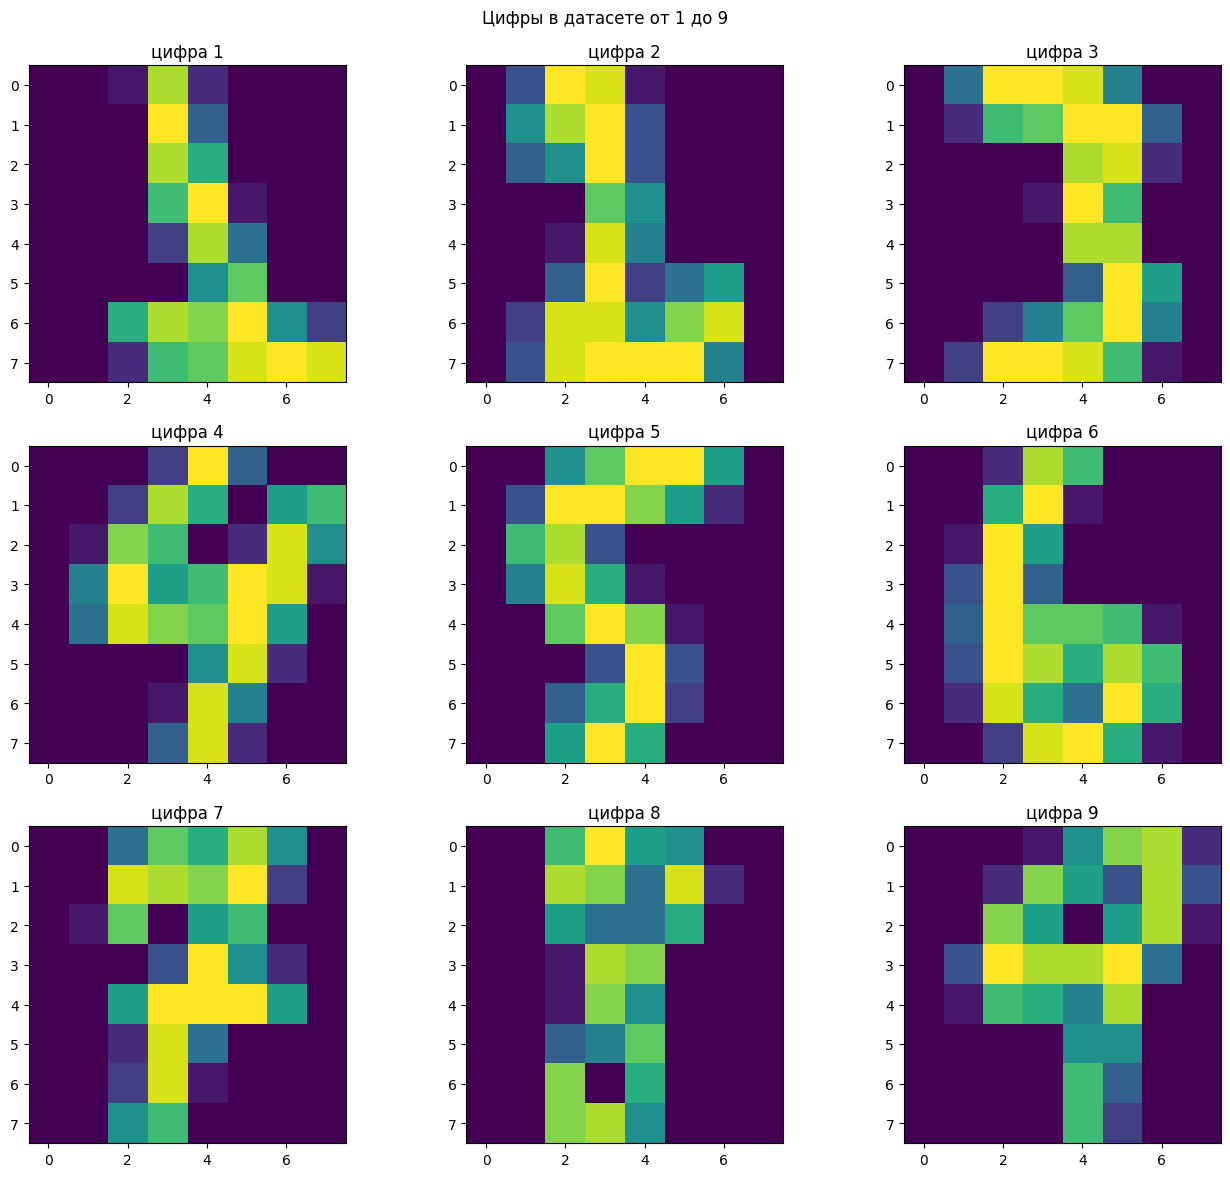

In [167]:
np.random.seed(42)

fig, axis = plt.subplots(3, 3)
fig.set_figwidth(16)
fig.set_figheight(14)

title = fig.suptitle('Цифры в датасете от 1 до 9')
title.set_position((0.5, 0.92))
for i, dig in enumerate(np.unique(y)[1:]):
    dig_indx = np.where(y == dig)
    rand_img = np.random.choice(dig_indx[0])

    axis[i // 3][i % 3].imshow(X[rand_img].reshape((8, 8)))
    axis[i // 3][i % 3].set_title(f'цифра {i + 1}')

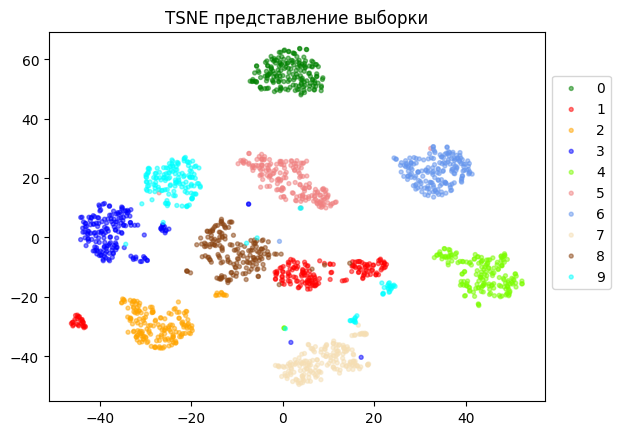

In [220]:
tsne = TSNE(n_components=2)
embeddings = tsne.fit_transform(X)
mapper = {
    0: 'green',
    1: 'red',
    2: 'orange',
    3: 'blue',
    4: 'lawngreen',
    5: 'lightcoral',
    6: 'cornflowerblue',
    7: 'wheat',
    8: 'saddlebrown',
    9: 'aqua'
}
colors = np.array(list(map(lambda x: mapper[x], y.tolist())))

for i in range(10):
    indexes = np.where(y == i)[0]
    plt.scatter(embeddings[indexes, 0], embeddings[indexes, 1],
                c=colors[indexes], label=f'{i}', alpha=0.5, s=8)

plt.title('TSNE представление выборки')
plt.legend(bbox_to_anchor=(1, 0.9))

Разделим данные на обучение и контроль:

In [200]:
from sklearn.model_selection import train_test_split

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [202]:
X_train.shape, X_test.shape

((1347, 64), (450, 64))

### `Сборка и обучение нейронной сети (0.8 балла)`

В нашей реализации мы представляем нейронную сеть в виде списка ее слоев. Например, следующая функция конструирует нейронную сеть заданной ширины (то есть с заданным размером скрытых слоев) и глубины (то есть с заданным количеством слоев) с заданным размером входа и выхода, а также с заданной функцией активации между линейными слоями.

In [413]:
def make_network(input_size, hidden_layers_size, output_size, n_layers=3, activation_class=ReLU):
    network = []

    for layer_idx in range(n_layers):
        # Compute sizes of current linear layer
        layer_in = input_size if layer_idx == 0 else hidden_layers_size
        layer_out = output_size if layer_idx == n_layers - 1 else hidden_layers_size

        # Add linear layer to the network
        network.append(Dense(layer_in, layer_out))

        # Add activation after each layer except the last one
        if layer_idx != n_layers - 1:
            network.append(activation_class())

    # Add LogSoftmax layer to the network
    network.append(LogSoftmax())

    return network

In [430]:
input_size = X_train.shape[1]
hidden_layers_size = 32
output_size = 10

network = make_network(input_size, hidden_layers_size, output_size, 3, ReLU)
network

[Dense(64, 32), Relu(), Dense(32, 32), Relu(), Dense(32, 10), LogSoftmax()]

Реализуйте функцию, которая выполнет прямой проход по нейронной сети:

In [293]:
def forward(network, X):
    """
    Perform forward pass through the network.

    network: list of layers
    X: raw data
    X shape: [batch, features_num]

    output: 
    output shape: [batch, out_features_num]
    """
    # your code here
    curr = X
    for layer in network:
        curr = layer.forward(curr)

    return curr

Для проверки, хорошо ли сеть обучилась, нам понадобится вычислять долю правильных ответов (accuracy) на данной выборке. Для этого реализуйте функцию, которая делает предсказания на каждом объекте (логично в качестве предсказания на очередном объекте выдавать тот класс, для которого предсказанный логарифм вероятности максимален):

In [294]:
def predict(network, X):
    """
    Returns predictions for each object in X.

    network: list of layers
    X: raw data
    X shape: [batch, features_num]

    output: array of classes, each from 0 to 9
    output shape: [batch]
    """
    # your code here
    probas = forward(network, X)

    return np.argmax(probas, axis=1)

In [298]:
predict(network, X_train[:100, :])

array([7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 1,
       3, 7, 7, 7, 7, 7, 7, 1, 7, 7, 1, 7, 7, 6, 7, 6, 4, 3, 7, 7, 1, 1,
       7, 7, 7, 3, 1, 7, 1, 4, 7, 4, 7, 4, 7, 1, 7, 7, 7, 1, 7, 7, 7, 7,
       3, 7, 7, 7, 1, 7, 1, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 4, 7, 1, 7,
       3, 1, 7, 4, 7, 7, 1, 7, 1, 7, 7, 7])

Мы будем обучать параметры нейросети с помощью готовой функции оптимизации из модуля `scipy`:

In [277]:
from scipy.optimize import minimize

In [279]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where ``x`` is a 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where ``n`` is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see he

Эта функция имеет стандартный интерфейс: нужно передать callable объект, который вычисляет значение и градиент целевой функции, а также точку старта оптимизации — начальное приближение (одномерный `numpy`-массив). Поэтому нам понадобятся функции для сбора и задания всех весов нашей нейросети (именно для них мы всегда записывали параметры слоя в список `layer.params`)

In [281]:
def get_weights(network):
    weights = []
    for layer in network:
        for param in layer.params:
            weights += param.ravel().tolist()
    return np.array(weights)


def set_weights(weights, network):
    i = 0
    for layer in network:
        for param in layer.params:
            l = param.size
            param[:] = weights[i:i+l].reshape(param.shape)
            i += l

Вам нужно реализовать ту самую функцию, которую мы будем передавать в `minimize`. Эта функция должна брать на вход текущую точку (вектор всех параметров), а также список дополнительных параметров (мы будем передавать через них нашу сеть и обучающие данные) и возвращать значение критерия качества (NLL) и его градиент по параметрам модели.

In [402]:
def compute_loss_grad(weights, args):
    """
    takes current weights and computes cross-entropy and gradients
    weights shape: [num_parameters]
    output 1: loss (scalar)
    output 2: gradient w.r.t. weights, shape: [num_parameters]

    hint: firstly perform forward pass through the whole network
    then compute loss and its gradients
    then perform backward pass, transmitting first baskward output
    to the previos layer and saving second baskward output in a list
    finally flatten all the gradients in this list
    (in the order from the first to the last layer)

    Do not forget to set weights of the network!
    """
    network, X, y = args

    set_weights(weights, network)

    out = forward(network, X)
    loss = NLL(out, y)
    curr_grad = grad_NLL(out, y)

    param_list_reversed = []

    for layer in network[::-1]:
        curr_grad, params_grad = layer.backward(curr_grad)
        param_list_reversed.append(params_grad)

    ravel_grad = np.hstack([
        x for xs in param_list_reversed[::-1] for x in xs
    ])

    print('-' * 15)
    print('loss:    ', loss)
    print('gradient:', np.linalg.norm(ravel_grad))
    print('-' * 15)

    return loss, ravel_grad

In [403]:
compute_loss_grad(get_weights(network), (network, X_train, y_train))

---------------
loss:     2.3026382166878396
gradient: 0.022774565202393314
---------------


(2.3026382166878396,
 array([0.        , 0.        , 0.        , ..., 0.00275676, 0.00632004,
        0.00120275]))

Теперь мы готовы обучать нашу нейросеть. 

In [431]:
weights = get_weights(network)

In [432]:
res = minimize(
    compute_loss_grad, weights,       # fun and start point
    args=[network, X_train, y_train],  # args passed to fun
    method="L-BFGS-B",                # optimization method
    jac=True                          # says that gradient is computed in fun
)

---------------
loss:     2.3025185695010837
gradient: 0.0238278084895258
---------------
---------------
loss:     2.3043586572798946
gradient: 0.30940673044660333
---------------
---------------
loss:     2.2983334860583358
gradient: 0.11750174187080255
---------------
---------------
loss:     2.284953449490033
gradient: 0.34542743116790814
---------------
---------------
loss:     7.262571800028662
gradient: 34.689816621013875
---------------


---------------
loss:     2.284106150622998
gradient: 0.38871742213143445
---------------
---------------
loss:     2.274714567877946
gradient: 0.7549413638477845
---------------
---------------
loss:     2.2551347804903368
gradient: 0.6937209846201517
---------------
---------------
loss:     2.0623735885305665
gradient: 1.8055907765230534
---------------
---------------
loss:     2.251819695803693
gradient: 9.794596206089718
---------------
---------------
loss:     1.9830905334845235
gradient: 3.4430085278168865
---------------
---------------
loss:     5.836004895742178
gradient: 32.65021720319527
---------------
---------------
loss:     1.8543916517086703
gradient: 3.406467791537196
---------------
---------------
loss:     18.258999380104537
gradient: 64.16358146751186
---------------
---------------
loss:     1.7978574173773154
gradient: 3.0453386797562727
---------------
---------------
loss:     1.9520800015528728
gradient: 8.015132013652437
---------------
---------------
lo

In [424]:
res.keys()

dict_keys(['fun', 'jac', 'nfev', 'njev', 'nit', 'status', 'message', 'x', 'success', 'hess_inv'])

In [425]:
res["nit"]  # number of iterations (should be >> 10)

116

In [426]:
res["success"]  # should be True

True

In [427]:
res["x"]  # leraned weights

array([ 0.00303703,  0.00210177, -0.00391365, ..., -0.59617367,
       -1.59697341, -0.24425791])

Выведите качество на обучении (`X_train`, `y_train`) и на контроле (`X_test`, `y_test`). Не забудьте установить веса!

In [433]:
# your code here
from sklearn.metrics import accuracy_score
set_weights(weights=res["x"], network=network)

train_NLL = NLL(forward(network, X_train), y_train)
test_NLL = NLL(forward(network, X_test), y_test)

print(f"Train NLL: {train_NLL:.7f}\t\tTest NLL: {test_NLL:.7f}")

train_accuracy = accuracy_score(
    y_true=y_train, y_pred=predict(network, X_train))
test_accuracy = accuracy_score(y_true=y_test, y_pred=predict(network, X_test))

print(f"Train accuracy: {train_accuracy:.3f}\t\tTest accuracy: {
      test_accuracy:.3f}")

Train NLL: 0.0000006		Test NLL: 0.8929787
Train accuracy: 1.000		Test accuracy: 0.949


У `minimize` есть также аргумент `callback` — в нее можно передать функцию, которая будет вызываться после каждой итерации оптимизации. Такую функцию удобно оформить в виде метода класса, который будет сохранять качество на обучении контроле после каждой итерации. Реализуйте этот метод в классе `Callback`:

In [35]:
class Callback:
    def __init__(self, network, X_train, y_train, X_test, y_test, print=False):
        self.network = network
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.print = print
        self.train_acc = []
        self.test_acc = []

    def call(self, weights):
        """
        Computes quality on train and test set with given weights
        and saves to self.train_acc and self.test_acc.
        If self.print is True, also prints these 2 values
        """
        # your code here

In [36]:
cb = Callback(network, X_train, y_train, X_test, y_test, print=True)

res = minimize(
    compute_loss_grad, weights,
    args=[network, X_train, y_train],
    method="L-BFGS-B",
    jac=True,
    callback=cb.call
)

Изобразите на графике кривую качества на обучени и контроле по итерациям:

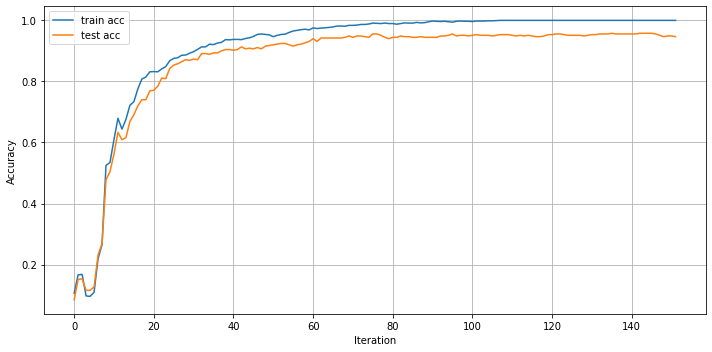

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(cb.train_acc, label="train acc")
ax.plot(cb.test_acc, label="test acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

### `Эксперименты с числом слоев (0.6 балла)`

Ясно, что из-за случайного начального приближения с каждым запуском обучения мы будем получать различное качество. Попробуем обучить нашу нейросеть с разным числом слоев несколько раз.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети с $i+1$ полносвязными слоями при $j$-м запуске (все запуски идентичны).

In [38]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [39]:
# your code here

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

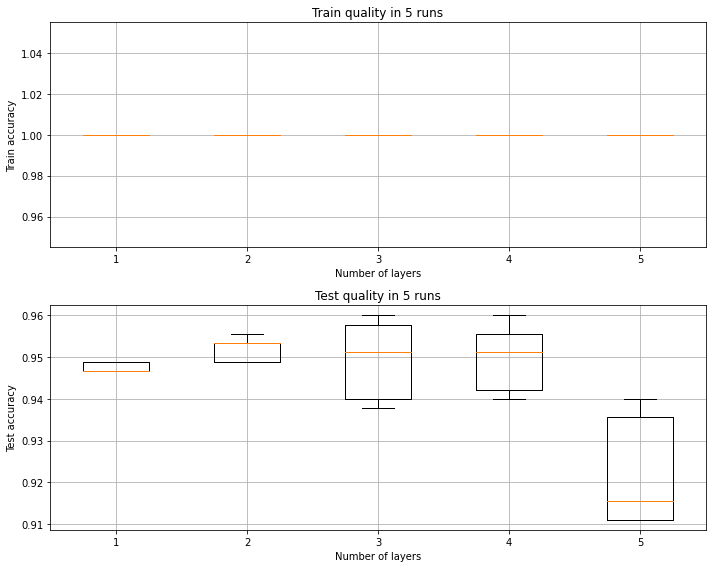

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, showfliers=False)
axes[1].boxplot(accs_test.T, showfliers=False)

axes[0].set_xlabel("Number of layers")
axes[1].set_xlabel("Number of layers")

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_title("Train quality in 5 runs")
axes[1].set_title("Test quality in 5 runs")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как изменяются качество на обучении и контроле и устойчивость процесса обучения при увеличении числа слоев?
* Можно ли сказать, что логистическая регрессия (линейная модель) дает качество хуже, чем нелинейная модель?

__Ответы:__

...

### `Эксперименты c различными инициализациями весов (0.6 балла)`

Как уже было сказано, начальная инициализация весов нейронной сети может сильно влиять на процесс ее обучения и, как следствие, на ее качество.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными инициализациями слоев.

Для этого необходимо реализовать функцию, инициализирующую веса линейных слоёв нашей нейронной сети. Добавьте в функционал данного метода возможность инициализировать его веса с помощью инициализации Kaiming (используется, если в нейронной сети в качестве функций активации используется ReLU) и инициализации Xavier (используется, если в нейронной сети в качестве функций активации используется Tanh или Sigmoid):

In [41]:
def initialize_network(network, initialization):
    for layer in network:
        if isinstance(layer, Dense):
            input_units, output_units = layer.weights.shape
            if initialization == 'Kaiming':
                # your code here
                pass
            elif initialization == 'Xavier':
                # your code here
                pass
            else:
                # Initialize weights with small random numbers from normal distribution.
                # In this case `initialization` represents a standard deviation
                # for normal distribution.
                layer.weights = np.random.randn(
                    input_units, output_units) * initialization
            layer.biases = np.zeros_like(layer.biases)

            layer.params = [layer.weights, layer.biases]

Теперь попробуйте для каждой из 3 инициализаций обучить нейронную сеть несколько раз. Попробуйте проделать данную операцию при зафиксированном числе слоев равным 3, 4 и 5.

#### `3 слоя`

Зафиксируйте в сети число слоев равное трем.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с инициализацией Kaiming при $i = 3$, с инициализацией Xavier при $i = 4$ и с инициализацией из нормального распределения с фиксированными параметрами при $0 \leqslant i \leqslant 2$ (попробуйте здесь 3 разных параметра для стандартного отклонения для нормального распределения, например: `1e-3`, `1e-2`, `1e-1`). Заметьте, что при большом числе слоев слишком низкое стандартное отклонение может не давать нейронной сети нормально обучиться.

In [61]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [62]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [63]:
# your code here

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

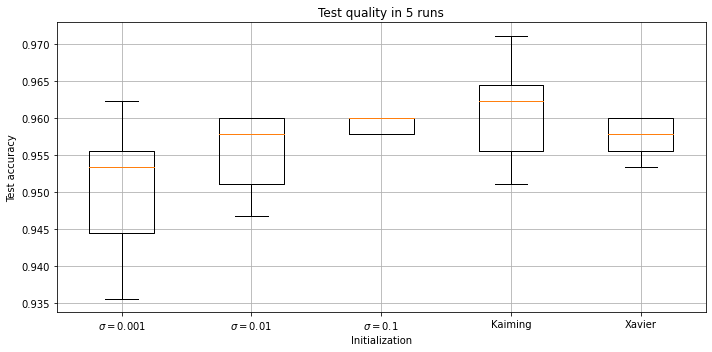

In [64]:
init_vars_for_plot = [
    (x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

#### `4 слоя`

Выполните тут тот же код, что и в предыдущем пункте, но только уже с 4 слоями в сети.

In [65]:
init_vars = [5e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [66]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [67]:
# your code here

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

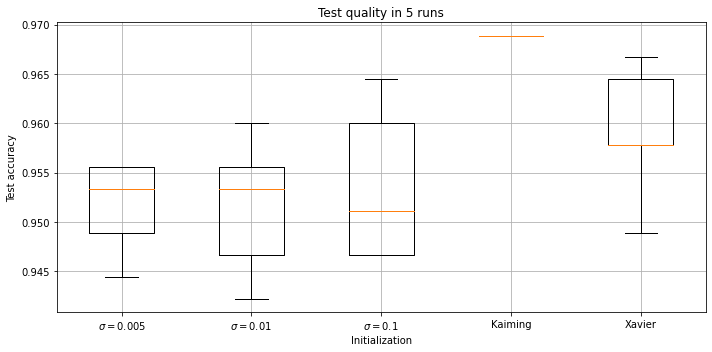

In [68]:
init_vars_for_plot = [
    (x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

#### `5 слоев`

Выполните тут тот же код, что и в предыдущем пункте, но только уже с 5 слоями в сети.

In [69]:
init_vars = [1e-2, 1e-1, 1e0, 'Kaiming', 'Xavier']

In [70]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [71]:
# your code here

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

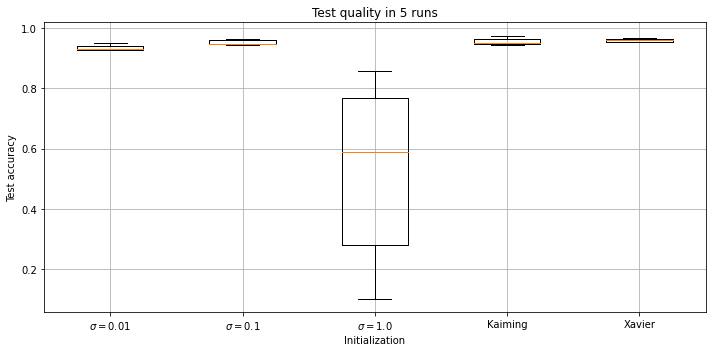

In [72]:
init_vars_for_plot = [
    (x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Initialization")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как отличаются качество на обучении и контроле и устойчивость процесса обучения при различных инициализациях?
* Какие инициализации помогают обучать более глубокие сети?

__Ответы:__

...

Теперь сравним скорость обучения при различных инициализациях. Создайте два списка списков `accs_test_on_iterations`, `accs_train_on_iterations` в каждом из которых в позиции `[i]` (см. описание `i` в предыдущем пункте) будет лежать список из значений `accuracy` на тестовой и обучающей выборках соотвественно, полученных во время обучения модели. Количество слоев в сети зафиксируйте равным 4.

In [75]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [76]:
accs_test_on_iterations = []
accs_train_on_iterations = []

In [77]:
# your code here

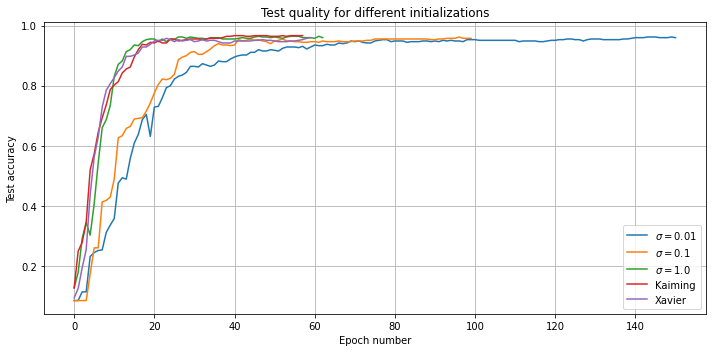

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for idx, label in enumerate(init_vars_for_plot):
    ax.plot(accs_test_on_iterations[idx], label=label)

ax.set_title("Test quality for different initializations")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Test accuracy")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как меняется скорость обучения в зависимости от выбранной инициализации?

__Ответы:__

...

### `Эксперименты c различными функциями активации (0.6 балла)`

Проверим теперь, с какой функцией активации нейронная сеть будет обучаться лучше.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными функциями активации.

Для этого нам нужно реализовать еще 2 слоя: для функций активации `Tanh` и `Sigmoid`.

In [49]:
class Tanh:
    """
    tanh(y) = (e^y - e^(-y)) / (e^y + e^(-y))
    Используйте функцию np.tanh для подсчета гиперболического тангенса.
    Вы можете сами реализовать подсчет tanh, но тогда вам нужно устойчиво его вычислять.
    """

    def __init__(self):
        self.params = []  # Tanh has no parameters

    def forward(self, input):
        """
        Apply elementwise Tanh to [batch, num_units] matrix
        """
        # your code here

    def backward(self, grad_output):
        """
        Compute gradient of loss w.r.t. Tanh input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        # your code here

    def __repr__(self):
        return 'Tanh()'

In [50]:
from scipy.special import expit


class Sigmoid:
    """
    sigmoid(y) = 1 / (1 + e^(-y))
    Используйте функцию expit для подсчета сигмоиды.
    Вы можете сами реализовать подсчет сигмоиды, но тогда вам нужно устойчиво ее вычислять.
    """

    def __init__(self):
        self.params = []  # Sigmoid has no parameters

    def forward(self, input):
        """
        Apply elementwise Sigmoid to [batch, num_units] matrix
        """
        # your code here

    def backward(self, grad_output):
        """
        Compute gradient of loss w.r.t. Sigmoid input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        # your code here

    def __repr__(self):
        return 'Sigmoid()'

Теперь попробуйте для каждой из 3 функций активации обучить нейронную сеть несколько раз. Число слоев зафиксируйте равным 3. В случае `Tanh` и `Sigmoid` используйте инициализацию `Xavier`, а в случае `ReLU` используйте инициализацию `Kaiming`.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с функцией активации $ReLU$ при $i = 0$, с функцией активации $Tanh$ при $i = 1$ и с функцией активации $Sigmoid$ при $i = 2$.

In [51]:
act_func_vars = ['Tanh', 'Sigmoid', 'ReLU']
init_for_act_funcs = ['Xavier', 'Xavier', 'Kaiming']

In [52]:
accs_train = np.zeros((3, 5))
accs_test = np.zeros((3, 5))

In [53]:
# your code here

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

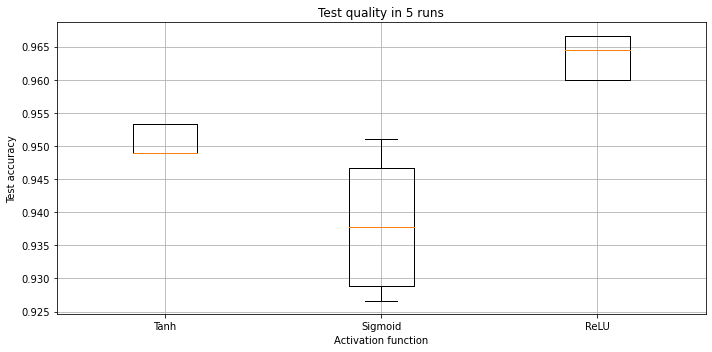

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.boxplot(accs_test.T, labels=act_func_vars, showfliers=False)

ax.set_title("Test quality in 5 runs")
ax.set_xlabel("Activation function")
ax.set_ylabel("Test accuracy")
ax.grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как отличаются качество на обучении и контроле и устойчивость процесса обучения при различных функциях активации?

__Ответы:__

...

\* Несколько фрагментов кода в задании написаны на основе материалов [курса по глубинному обучению на ФКН НИУ ВШЭ](https://www.hse.ru/ba/ami/courses/205504078.html)

### `Реализация метода оптимизации (1.4 балла)`

В этой части задания реализуйте метод оптимизации SGD + momentum. Упрощённая версия более общего алгоритма [отсюда](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

$$
\begin{aligned}
    &\rule{70mm}{0.4pt}                                                             \\
    &\textbf{input}      : \gamma \text{ (lr)}, \: \theta_0 \text{ (params)}, \: X \text{ (data)},       \\
    &\hspace{13mm} \: f(\theta) \text{ (objective)}, \:\mu \text{ (momentum)}       \\[-1.ex]
    &\rule{70mm}{0.4pt}                                                             \\
    &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                    \\
    &\hspace{5mm}\mathcal{X} \leftarrow \texttt{list\_of\_random\_batches}(X)\\
    &\hspace{5mm}\textbf{for} \: i=1 \: \textbf{to} \: \ldots \: \textbf{do}                    \\
    &\hspace{10mm}g_t\leftarrow   \nabla_{\theta} f_t (\theta_{t-1},\mathcal{X}_i)      \\
    &\hspace{10mm}\textbf{if} \: \mu \neq 0                                          \\
    &\hspace{15mm}\textbf{if} \: t > 1                                              \\
    &\hspace{20mm} \textbf{b}_t \leftarrow \mu \textbf{b}_{t-1} + g_t               \\
    &\hspace{15mm}\textbf{else}                                                     \\
    &\hspace{20mm} \textbf{b}_t \leftarrow g_t                                      \\
    &\hspace{15mm} g_t  \leftarrow  \textbf{b}_t                                     \\
    &\hspace{10mm}\theta_t \leftarrow \theta_{t-1} - \gamma g_t                      \\[-1.ex]
    &\rule{70mm}{0.4pt}                                                             \\[-1.ex]
    &\bf{return} \:  \theta_t                                                       \\[-1.ex]
    &\rule{70mm}{0.4pt}                                                             \\[-1.ex]
\end{aligned}
$$

Проще всего будет написать `custom minimizer` (смотри [документацию scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)).

In [ ]:
from scipy.optimize import OptimizeResult


def SGD(fun, x0, args, **kwargs) -> OptimizeResult:
    # feed weights from each iteration to update network and log metrics
    callback = kwargs['callback']
    mu = kwargs['momentum']
    n_iter = kwargs['n_iter']
    gamma = kwargs['lr']
    jac = kwargs['jac']
    batch_size = kwargs['batch_size']

    net, X, y = args

    # your code is here

**Задание 1. (0.5 балла)** Продемонстрируйте правильную работу метода оптимизации, получив `test_accuracy>=0.9`.

In [ ]:
# your code is here

**Задание 2. (0.8 балла)** Сравните три алгоритма:
1. LBFGS-B
2. SGD
3. SGD + momentum

Для этого одновременно переберите следующие гиперпараметры:
- значения `lr` на отрезке `[1e-3, 1e-1]` по логарифмической сетке
- два значения `momentum`: `0` и `0.9`
- значения `batch_size`: `8` и `32`

В каждом запуске сохраняйте три метрики: итоговое accuracy на тесте и на трейне и время обучения.

Для каждого из трёх алгоритмов выберите лучшие `lr` и `batch_size` по `test_accuracy`. Постройте для них кривые обучения (пример ниже). Сделайте выводы.

![](comparison.svg)

In [ ]:
# your code is here

**Выводы:**

**Задание 3. (0.1 балла)** Для отобранных в прошлом задании трёх алгоритмов ответье на вопрос: как меняются запуски для двух значений `batch_size`.

**Ответ:**

## `Бонусная часть`

### `Реализация метода оптимизации (1 балл)`

Реализуйте метод оптимизации Adam и сравните его работу с SGD + momentum, проведя эксперимент, как в задании 2 (перебор гиперпараметров + кривые обучения).

### `Dropout (1 балл)`

Реализуйте слой Dropout. Сравните обучение сети из большого числа слоёв при использовании Dropout и без его использования (предварительно подберите адекватный параметр $p$). Сделайте выводы.

### `BatchNormalization (1 балл)`

Реализуйте слой `BatchNormalization`. Сравните обучение сети из большого числа слоёв при использовании `BatchNormalization` и без его использования. Сделайте выводы.